# Quantum Support Vector Machine

Code Reference: [Kernel-based training of quantum models with scikit-learn](https://pennylane.ai/qml/demos/tutorial_kernel_based_training)

## Load Packages

In [34]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, classification_report

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)

## Load Data

1. Load first 100 data to get the first 2 classes. Use only first 2 features for simplicity
2. scale the features using standard scaler
3. scale / convert the labels from (0,1) to (-1, 1)

In [2]:
# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
 # Consider only the first two features for simplicity
#0: 0-49, 1:50-99, 2:100-149
iris = datasets.load_iris()
X = iris.data[:100, :2] 
y = iris.target[:100]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_train_scaled = 2 * (y_train - 0.5)
y_test_scaled = 2 * (y_test - 0.5)

We use the angle-embedding template which needs as many qubits as there are features:

In [4]:
n_qubits = len(X_train_scaled[0])
n_qubits

2

## Define a quantum kernel function 

The `AngleEmbedding` operation is a quantum circuit that encodes classical input data as rotation angles of qubits' state vectors, effectively mapping classical information to a quantum state.

In [5]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel, interface="autograd")
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

sanity check is whether evaluating the kernel of a data point and itself returns 1

In [6]:
kernel(X_train_scaled[0], X_train_scaled[0])

tensor(1., requires_grad=True)

In [7]:
kernel(X_train_scaled[0], X_train_scaled[1])

tensor(0.25349075, requires_grad=True)

In [8]:
kernel(X_train_scaled[0], X_train_scaled[2])

tensor(4.43631278e-05, requires_grad=True)

Compute matrix that represents the similarity or dissimilarity between the elements of A and B based on the specified kernel.

In [9]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

Instead of using a predefined kernel like linear or radial basis function (RBF), the SVM model will use the custom kernel defined by `kernel_matrix`.

In [10]:
svm_quantum = SVC(kernel=kernel_matrix).fit(X_train_scaled, y_train_scaled)

In [11]:
predictions_train_quantum = svm_quantum.predict(X_train_scaled) 
predictions_test_quantum = svm_quantum.predict(X_test_scaled)

In [12]:
def get_metrics(y_train, y_test, predictions_train, predictions_test):
    # Calculate accuracy
    accuracyTrain = accuracy_score(predictions_train, y_train)
    accuracyTest = accuracy_score(predictions_test, y_test)
    
    # Calculate precision and recall
    precisionTrain = precision_score(y_train, predictions_train)
    recallTrain = recall_score(y_train, predictions_train)
    
    precisionTest = precision_score(y_test, predictions_test)
    recallTest = recall_score(y_test, predictions_test)
    
    # Print accuracy, precision, and recall
    print("Train Accuracy:", accuracyTrain)
    print("Train Precision:", precisionTrain)
    print("Train Recall:", recallTrain)
    
    print("Test Accuracy:", accuracyTest)
    print("Test Precision:", precisionTest)
    print("Test Recall:", recallTest)
    
    # Calculate false positive rate (FPR), true positive rate (TPR), and AUC for ROC curve
    fpr, tpr, _ = roc_curve(y_test, predictions_test)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Train Accuracy: 0.9866666666666667
Train Precision: 0.975
Train Recall: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0


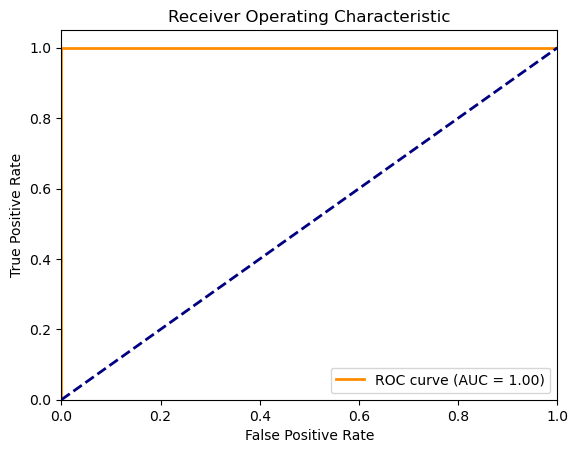

In [13]:
get_metrics(y_train_scaled, y_test_scaled, predictions_train_quantum, predictions_test_quantum)

Visualize the decision boundary on X_train_scaled.

In [64]:
def visualize_decision_boundary(svm, X, y):
    # Create a meshgrid of points to visualize the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = []
    total_iterations = len(xx.ravel())
    
    # Use tqdm to track the progress of the predictions
    with tqdm(total=total_iterations, desc='Predicting', unit='iteration') as pbar:
        for i, j in zip(xx.ravel(), yy.ravel()):
            # Predict the class for each point in the meshgrid
            Z.append(svm.predict([[i, j]]))
            pbar.update(1)
    
    Z = np.array(Z)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8)
    
    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
    
    # Add labels and title
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.title('SVM Decision Boundary on Iris Dataset')
    
    # Show the plot
    plt.show()

In [47]:
# takes 3h
# visualize_decision_boundary(svm_quantum, X_train_scaled, y_train_scaled)

In [48]:
len(X_train_scaled)

75

In [66]:
# take 1.5h
# visualize_decision_boundary(svm_quantum, X_train_scaled[:5], y_train_scaled[:5])

## Classical SVM Model

In [16]:
# Train the classical SVM model
svm_classical = SVC(kernel='linear')
svm_classical.fit(X_train_scaled, y_train_scaled)

SVC(kernel='linear')

In [17]:
predictions_train_classical = svm_classical.predict(X_train_scaled) 
predictions_test_classical = svm_classical.predict(X_test_scaled)

Train Accuracy: 0.9866666666666667
Train Precision: 0.975
Train Recall: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0


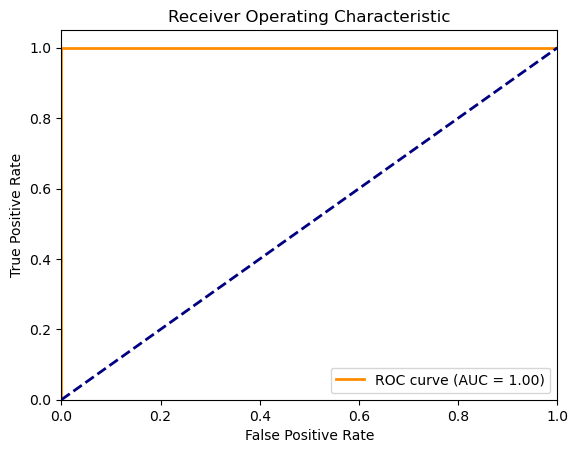

In [18]:
get_metrics(y_train_scaled, y_test_scaled, predictions_train_classical, predictions_test_classical)

Predicting: 100%|█████████████████████████████████████████████████| 108018/108018 [00:03<00:00, 28153.63iteration/s]


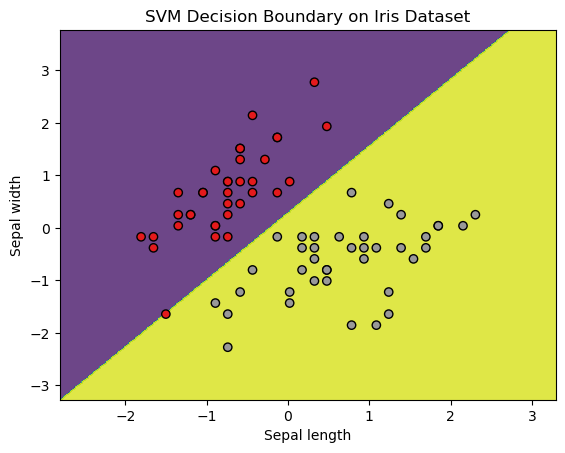

In [44]:
visualize_decision_boundary(svm_classical, X_train_scaled, y_train_scaled)